In [20]:
from PIL import Image
import numpy as np
import math
import typing
import random

In [21]:
def initialize_2dimage(dimensions: tuple, background_color: tuple) -> list:
    return [[background_color for _ in range(dimensions[1])] for _ in range(dimensions[0])]

In [22]:
def line_2d(point_1: tuple, point_2: tuple):
    x1, y1 = point_1
    x2, y2 = point_2
    assert not (x1%1 and x2%1 and y1%1 and y2%1), f"input points must whole numbers not decimals: input : {x1},{x2},{y1},{y2} "
    difference_x = abs(x2 - x1)
    difference_y = abs(y2 - y1)
    if x2 > x1:
        x_sign = 1
    else:
        x_sign = -1
    if y2 > y1:
        y_sign = 1
    else:
        y_sign = -1
    if max(difference_x,difference_y) == difference_x:
        y_error = 2*difference_y - difference_x
        yield (int(x1),int(y1))
        while x1 != x2:
            x1 += x_sign
            if y_error >= 0:
                y1 += y_sign
                y_error -= 2 * difference_x
            y_error += 2 * difference_y 
            yield (int(x1),int(y1))
    elif max(difference_x,difference_y) == difference_y:
        x_error = 2*difference_x - difference_y
        yield (int(x1),int(y1))
        while y1 != y2:
            y1 += y_sign
            if x_error >= 0:
                x1 += x_sign
                x_error -= 2 * difference_y
            x_error += 2 * difference_x 
            yield (int(x1),int(y1))

In [23]:
def save_image(pixels: list, image_name: str):
    pixels = list(zip(*pixels))[::-1]
    array = np.array(pixels, dtype=np.uint8)
    new_image = Image.fromarray(array)
    display(new_image)
    new_image.save(image_name + '.png')

In [24]:
class camera:
    def __init__(self, fov: int, vertical_fov: int, resolution: tuple, location: tuple, direction: tuple, view_distance: tuple):
        self.fov = fov
        self.vertical_fov = vertical_fov
        self.resolution = resolution
        self.location = location
        self.direction = direction
        self.view_distance = view_distance

In [25]:
class mesh3D:
    def __init__(self, verticies: list, faces: list, center: tuple):
        self.verticies = verticies
        self.faces = faces
        self.center = center

In [26]:
def global_cords(center: np.ndarray, model_verticies: list):
    transformation_matrix = np.array([[1,0,0,center[0]],[0,1,0,center[1]],[0,0,1,center[2]],[0,0,0,1]])
    return [np.dot(transformation_matrix,vertex) for vertex in model_verticies]

In [27]:
def reorient_to_camera(self, cam: camera, global_cords: list):
    assert type(global_cords) == list
    for cord in global_cords:
        assert type(cord) == np.ndarray
    transformation_matrix = np.array([[1,0,0,-cam.location[0]],[0,1,0,-cam.location[1]],[0,0,1,-cam.location[2]],[0,0,0,1]])
    x_rotation_matrix = np.array([[1,0,0,0],[0,math.cos(math.radians(-cam.direction[0])),-math.sin(math.radians(-cam.direction[0])),0],[0,math.sin(math.radians(-cam.direction[0])),math.cos(math.radians(-cam.direction[0])),0],[0,0,0,1]])
    y_rotation_matrix = np.array([[math.cos(math.radians(-cam.direction[1])),0,math.sin(math.radians(-cam.direction[1])),0],[0,1,0,0],[-math.sin(math.radians(-cam.direction[1])),0,math.cos(math.radians(-cam.direction[1])),0],[0,0,0,1]])
    z_rotation_matrix = np.array([[math.cos(math.radians(-cam.direction[2])),-math.sin(math.radians(-cam.direction[2])),0,0],[math.sin(math.radians(-cam.direction[2])),math.cos(math.radians(-cam.direction[2])),0,0],[0,0,1,0],[0,0,0,1]])
    return [np.dot(np.dot(np.dot(np.dot(point,transformation_matrix),x_rotation_matrix),y_rotation_matrix),z_rotation_matrix) for point in global_cords]

In [28]:
#remove clipping for new clipping
def clipping(cam: camera, oriented_to_camera_verticies: list, faces: list):
    clipped = []
    for face in faces:
        for point_idx in face:
            point = oriented_to_camera_verticies[point_idx]
            if cam.fov >= abs(math.degrees(math.tan(point[0]/point[2]))) and cam.vertical_fov >= abs(math.degrees(math.tan(point[1]/point[2]))) and cam.view_distance[1] >= point[2] >= cam.view_distance[0]:
                clipped.append(face)
                break
    return clipped

In [29]:
def back_culling(oriented_to_camera_verticies: list, clipped: list):
    culled_faces = []
    for face in clipped:
        ax, ay, az, _ = oriented_to_camera_verticies[face[0]]
        bx, by, bz, _  = oriented_to_camera_verticies[face[1]]
        cx, cy, cz, _  = oriented_to_camera_verticies[face[2]]
        vector1 = np.array([bx-ax, by-ay, bz-az])
        vector2 = np.array([bx-cx, by-cy, bz-cz])
        angle = np.cross(vector1, vector2)
        if np.dot(angle, oriented_to_camera_verticies[face[1]][:2]) < 0:
            culled_faces.append(face)
    return culled_faces

In [30]:
def perspective_projection(cam: camera, oriented_to_camera_verticies: list):
    projection_matrix = np.array([[cam.view_distance[0]/math.tan(math.radians(cam.fov/2)),0,0,0],[0,cam.view_distance[0]/math.tan(math.radians(cam.vertical_fov/2)),0,0],[0,0,cam.view_distance[1]-cam.view_distance[0],-cam.view_distance[0]*cam.view_distance[0]],[0,0,1,0]])
    points_in_2d = []
    for vertex in oriented_to_camera_verticies:
        homogeneous_point = np.dot(vertex, projection_matrix)
        if homogeneous_point[3]:
            homogeneous_point = np.asarray([homogeneous_point[0]/homogeneous_point[3],homogeneous_point[1]/homogeneous_point[3],homogeneous_point[3],1])
        points_in_2d.append(homogeneous_point)
    return points_in_2d

In [31]:
def screen_space(cam: camera, verticies: list):
    return [np.array([round((vertex[0]+1)*cam.resolution[0]/2),round((vertex[1]+1)*cam.resolution[1]/2),vertex[2],1]) for vertex in verticies]

In [44]:
def rasterization(cam: camera, canvas: list, height_map: list, screen_verticies: list, world_space_verticies: list, faces: list, border_color: tuple, fill_color: tuple):
    for face in faces:
        ax, ay, az, _ = screen_verticies[face[0]]
        bx, by, bz, _  = screen_verticies[face[1]]
        cx, cy, cz, _  = screen_verticies[face[2]]
        vector1 = np.array([bx-ax, by-ay, bz-az])
        vector2 = np.array([bx-cx, by-cy, bz-cz])
        bearing = np.cross(vector1, vector2)


        if bearing[2] == 0:
            continue # face is completely vertial when looking at it and does not need to be rendered
        else:
            if bearing[0] == 0:
                x_slope = 0
            else:
                x_slope = (-1)/(bearing[2]/bearing[0])
            if bearing[1] == 0:
                y_slope = 0
            else:
                y_slope = (-1)/(bearing[2]/bearing[1])


        # adding infrastructure to change depth information




        # end experimental code


        z_intercept = screen_verticies[face[0]][2] - screen_verticies[face[0]][0]*x_slope - screen_verticies[face[0]][1]*y_slope
        overlap_counter = 0
        shape = np.zeros([cam.resolution[0], cam.resolution[1]]) 
        for idx, point_idx in enumerate(face):
            for x,y in line_2d([round(screen_verticies[point_idx][0]),round(screen_verticies[point_idx][1])],[round(screen_verticies[face[idx-1]][0]),round(screen_verticies[face[idx-1]][1])]):
                if 0 <= x <= cam.resolution[0]-1 and 0 <= y <= cam.resolution[1]-1:
                    if shape[x][y] == 1:
                        overlap_counter += 1
                    else:
                        shape[x][y] = 1 
                    z = z_intercept + x*x_slope + y*y_slope
                    if height_map[x][y] <= z <= cam.view_distance[0]:
                        canvas[x][y] = border_color
                        height_map[x][y] = z
        if overlap_counter < sum(sum(shape))/4:  #Also cuts out any faces that are completely off screen
            mid = sum(screen_verticies[point_idx][:2] for point_idx in face)/len(face)
            middle_point = np.append([round(mid[0]), round(mid[1])], z_intercept+round(mid[0])*x_slope+(mid[1])*y_slope)
            if middle_point[0] > cam.resolution[0]-1 or middle_point[0] < 0 or middle_point[1] > cam.resolution[1]-1 or middle_point[1] < 0: 
                valid_points = [screen_verticies[point_idx] for point_idx in face if 0 <= screen_verticies[point_idx][0] <= cam.resolution[0]-1 and 0 <= screen_verticies[point_idx][1] <= cam.resolution[1]-1]
                if valid_points:
                    inside_point = sum(valid_points)/len(valid_points)
                    for x,y in line_2d((round(middle_point[0]),round(middle_point[1])),(round(inside_point[0]),round(inside_point[1]))):
                        if 0 <= x <= cam.resolution[0]-1 and 0 <= y <= cam.resolution[1]-1:
                            middle_point = np.asarray([x,y,z_intercept+x*x_slope+y*y_slope])
                            break

            stack = [middle_point]

            while stack:
                x,y,z = stack[0]
                x,y = int(round(x)), int(round(y))
                stack.pop(0)
                if 0 <= x <= cam.resolution[0]-1 and 0 <= y <= cam.resolution[1]-1: 
                    if not shape[x][y]:
                        if z >= height_map[x][y]: 
                            canvas[x][y] = fill_color
                            height_map[x][y] = z
                        stack.append(np.asarray([x+1,y,z_intercept+(x+1)*x_slope+y*y_slope]))
                        stack.append(np.asarray([x-1,y,z_intercept+(x-1)*x_slope+y*y_slope]))
                        stack.append(np.asarray([x,y+1,z_intercept+x*x_slope+(y+1)*y_slope]))
                        stack.append(np.asarray([x,y-1,z_intercept+x*x_slope+(y-1)*y_slope]))
                    shape[x][y] = 1 

    return canvas

In [33]:
def create_cube_mesh(side_length: int, center: tuple, rotation: tuple):
    possible_diff = [side_length/2,-side_length/2]
    verticies = [np.array([xa,ya,za,1]) for xa in possible_diff for ya in possible_diff for za in possible_diff]
    x_rotation_matrix = np.array([[1,0,0,0],[0,math.cos(math.radians(rotation[0])),-math.sin(math.radians(rotation[0])),0],[0,math.sin(math.radians(rotation[0])),math.cos(math.radians(rotation[0])),0],[0,0,0,1]])
    y_rotation_matrix = np.array([[math.cos(math.radians(rotation[1])),0,math.sin(math.radians(rotation[1])),0],[0,1,0,0],[-math.sin(math.radians(rotation[1])),0,math.cos(math.radians(rotation[1])),0],[0,0,0,1]])
    z_rotation_matrix = np.array([[math.cos(math.radians(rotation[2])),-math.sin(math.radians(rotation[2])),0,0],[math.sin(math.radians(rotation[2])),math.cos(math.radians(rotation[2])),0,0],[0,0,1,0],[0,0,0,1]])
    #faces = [[0,1,2],[2,1,3],[6,4,2],[2,4,0],[4,5,0],[0,5,1],[7,5,6],[6,5,4],[3,7,2],[2,7,6],[3,7,1],[1,7,5]]
    faces = [[0,4,5,1],[0,2,3,1],[6,7,3,2],[4,6,7,5],[4,6,2,0],[7,5,1,3]]
    return mesh3D([np.dot(np.dot(np.dot(vertex,x_rotation_matrix),y_rotation_matrix),z_rotation_matrix) for vertex in verticies],faces,center)

In [34]:
def most_of_cube_rendering(canvas, height_map, cam, mesh, border_color, fill_color):
    world_verticies = global_cords(mesh.center, mesh.verticies)
    in_perspective_verticies = perspective_projection(cam, world_verticies)
    verticies = screen_space(cam, in_perspective_verticies)
    return rasterization(cam, canvas, height_map, verticies,world_verticies, mesh.faces, border_color, fill_color)

Unfinalized Code Below This Point

In [35]:
r_rotation  = lambda: random.randint(0,360)
#r_rotation  = lambda: 90
r_rgb  = lambda: random.randint(0,255)

r_distance  = lambda: random.randint(-500,500)
r_distance_z  = lambda: random.randint(300,1000)
r_size = lambda: random.randint(20,150)

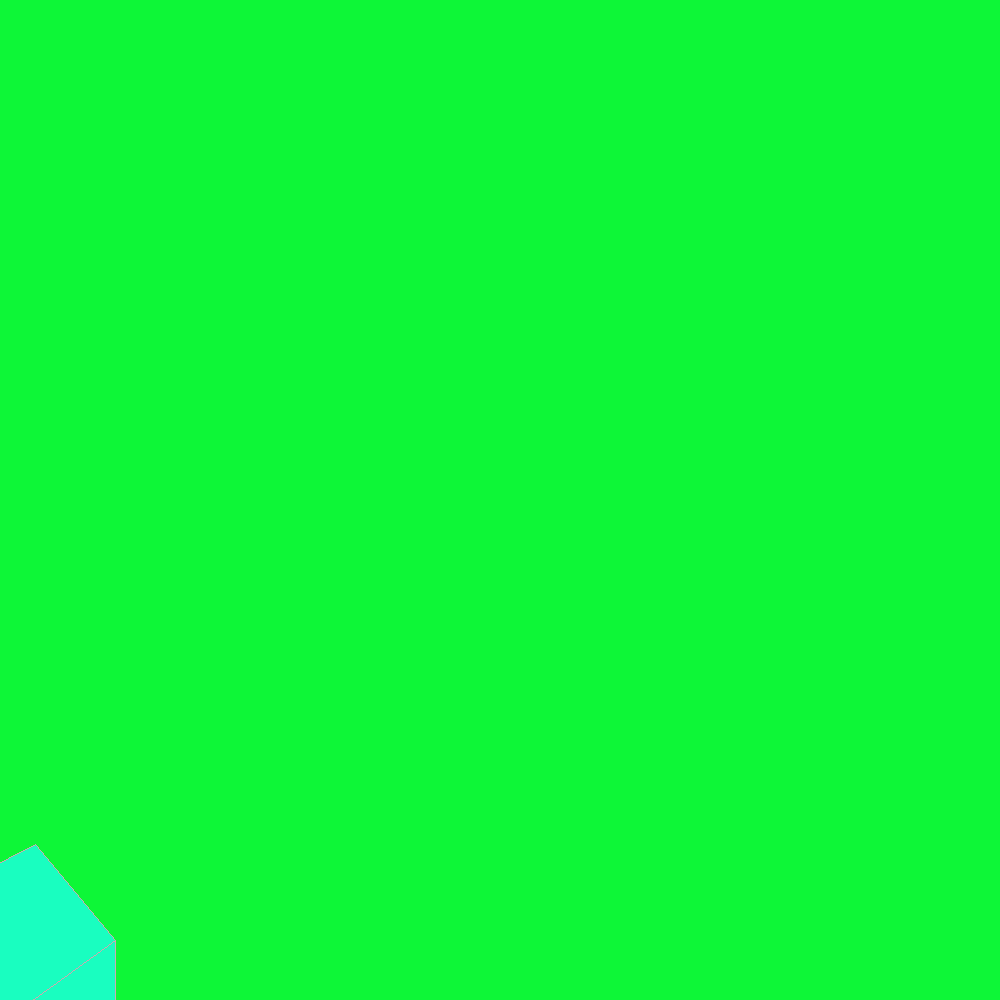

In [45]:
#initialize objects
cam1 = camera(90,90,(1000,1000),(0,0,0),(0,0,0),(1,1000))
canvas = initialize_2dimage((1000,1000),(r_rgb(),r_rgb(),r_rgb()))
height_map = np.zeros([1000,1000])-1000
mesh = create_cube_mesh(200, (550,550,500),(r_rotation(),r_rotation(),r_rotation()))

canvas = most_of_cube_rendering(canvas, height_map, cam1, mesh, (r_rgb(),r_rgb(),r_rgb()), (r_rgb(),r_rgb(),r_rgb()))


save_image(canvas, "perfect image")

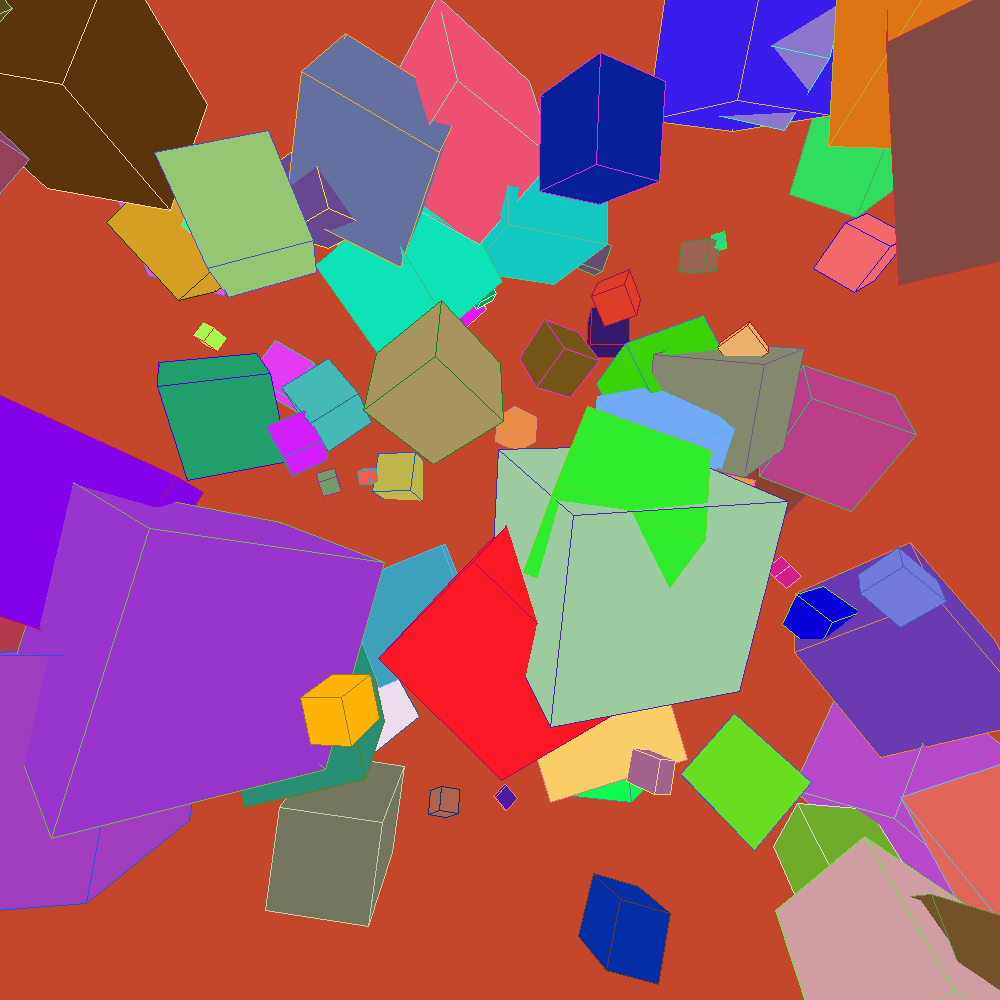

In [46]:
#initialize objects
cam1 = camera(90,90,(1000,1000),(0,0,0),(0,0,0),(1,1000))
canvas = initialize_2dimage((1000,1000),(r_rgb(),r_rgb(),r_rgb()))
height_map = np.zeros([1000,1000])-1000
mesh = create_cube_mesh(100, (-600,0,758),(r_rotation(),r_rotation(),r_rotation()))

for _ in range(100):
    canvas = most_of_cube_rendering(canvas, height_map, cam1, create_cube_mesh(r_size(), (r_distance(),r_distance(),r_distance_z()),(r_rotation(),r_rotation(),r_rotation())), (r_rgb(),r_rgb(),r_rgb()), (r_rgb(),r_rgb(),r_rgb()))


save_image(canvas, "perfect image")

Errors to fix
- certain edges and faces don't seem to be lining up exact in height
- certain lines are appearing at cube corners for no reason
- fix how it takes a really long time to render cubes on the edges
